In [9]:
import sys 
print(sys.version)

3.9.5 (default, May 18 2021, 14:42:02) [MSC v.1916 64 bit (AMD64)]


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical, pad_sequences
from keras.callbacks import EarlyStopping

In [11]:
# python version 3.8.6rc1
import pandas as pd
import string
import util
import io
import os
from pprint import pprint
import spacy
import pickle
import re
import numpy as np

import warnings
warnings.filterwarnings(action='once')
#warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

# import pyLDAvis
# import pyLDAvis.gensim_models
# import matplotlib.pyplot as plt
# import matplotlib
# %matplotlib inline
# import pandas as pd
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn import metrics
# from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Willi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Willi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Willi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Willi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


0    143346
1     16225
Name: harmful, dtype: int64


C:\Users\Willi\AppData\Local\Temp/ipykernel_10152/278609579.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments['harmful'][comments['harmful']>0] = 1


Text(0.5, 1.0, 'Number of harmful messages')

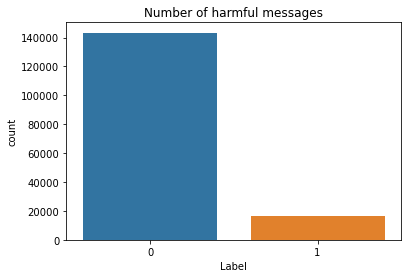

In [12]:
# Count number of rows with each label without considering combination
comments = pd.read_csv("train.csv")
#comments.iloc[:, 2:].sum(axis=0)

df_multilabel = comments

# convert into binary
comments['harmful'] = comments.iloc[:, 2:].sum(axis=1)
comments['harmful'][comments['harmful']>0] = 1

# keep necessary info
df = comments[['comment_text',"harmful"]]#.copy()

print(df['harmful'].value_counts())
df.head()

sns.countplot(df['harmful'])
plt.xlabel('Label')
plt.title('Number of harmful messages')

# Data Cleaning

In [32]:
def preprocess(df):
    def remove_punctuation(text):
        #return str(text).translate(str.maketrans('', '', string.punctuation))
        text_nopunct = "".join([char for char in str(text) if char not in string.punctuation])
        return text_nopunct

    def tokenize_text(text):
        tokens = nltk.word_tokenize(text) 
        tokens = [token.strip() for token in tokens]
        return tokens

    def remove_stopwords(tokens):
        stopword_list = nltk.corpus.stopwords.words('english')
        filtered_tokens = [token for token in tokens if token not in stopword_list]
        #filtered_text = ' '.join(filtered_tokens)    
        return filtered_tokens

    def expand_contractions(text, contraction_mapping):

        contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                          flags=re.IGNORECASE|re.DOTALL)
        def expand_match(contraction):
            match = contraction.group(0)
            first_char = match[0]
            expanded_contraction = contraction_mapping.get(match)\
                                    if contraction_mapping.get(match)\
                                    else contraction_mapping.get(match.lower())                       
            expanded_contraction = first_char+expanded_contraction[1:]
            return expanded_contraction

        expanded_text = contractions_pattern.sub(expand_match, text)
        expanded_text = re.sub("'", "", expanded_text)
        return expanded_text
    def remove_digit(text):
        text_nodigit = re.sub(r'\w*\d\w*', '',text).strip()
        return text_nodigit

    def stemming(tokenized_text):
        ps = nltk.PorterStemmer()
        stemmed = [ps.stem(word) for word in tokenized_text]
        return stemmed

    def lemmatize(tokenized_text):
        wn = nltk.WordNetLemmatizer()
        lemmatized = [wn.lemmatize(word) for word in tokenized_text]
        return lemmatized
    # expand_contractions -> remove_punctuation -> remove_digit -> tokenize_text -> remove_stopwords
    
    df["comment_text_clean"] = df["comment_text"].apply(lambda x: expand_contractions(x.lower(), util.contraction_mapping))
    df["comment_text_clean"] = df["comment_text_clean"].apply(lambda x: remove_punctuation(x))
    df["comment_text_clean"] = df["comment_text_clean"].apply(lambda x: remove_digit(x))
    #df["tokenized"] = df["comment_text_clean"].apply(lambda x: tokenize_text(x))
    #df['tokenized'] =  df["tokenized"].apply(lambda x: remove_stopwords(x))
    #df['stemmed'] =  df["tokenized"].apply(lambda x: stemming(x))
    #df['lemmatized'] =  df["tokenized"].apply(lambda x: lemmatize(x))
    return df

In [36]:
df_clean = preprocess(df)
df_clean.head()

C:\Users\Willi\AppData\Local\Temp/ipykernel_10152/1639223216.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["comment_text_clean"] = df["comment_text"].apply(lambda x: expand_contractions(x.lower(), util.contraction_mapping))


,comment_text,harmful,comment_text_clean,tokenized
0,Explanation\nWhy the edits made under my usern...,0,explanation\nwhy the edits made under my usern...,"[explanation, edits, made, username, hardcore,..."
1,D'aww! He matches this background colour I'm s...,0,daww he matches this background colour i am se...,"[daww, matches, background, colour, seemingly,..."
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i am really not trying to edit war it ...,"[hey, man, really, trying, edit, war, guy, con..."
3,"""\nMore\nI can't make any real suggestions on ...",0,more\ni cannot make any real suggestions on im...,"[make, real, suggestions, improvement, wondere..."
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,"[sir, hero, chance, remember, page]"


# LSTM

In [37]:
X = df_clean['comment_text_clean']
X = df_clean['comment_text']
Y = df_clean['harmful']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)


In [38]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 2000
# Max number of words in each complaint.
MAX_LENGTH = 200

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=MAX_LENGTH)

In [39]:
def LSTM():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [40]:
model = LSTM()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [41]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
848/848 [==============================] - 68s 78ms/step - loss: 0.1838 - accuracy: 0.9390 - val_loss: 0.1523 - val_accuracy: 0.9489
Epoch 2/10
848/848 [==============================] - 63s 74ms/step - loss: 0.1512 - accuracy: 0.9490 - val_loss: 0.1541 - val_accuracy: 0.9463


In [42]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)
accr = model.evaluate(test_sequences_matrix,Y_test)

748/748 [==============================] - 8s 10ms/step - loss: 0.1539 - accuracy: 0.9472


In [43]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.154
  Accuracy: 0.947
